In [1]:
# default_exp synthetic_data

In [2]:
# export

import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

from sklearn.neighbors import KernelDensity

In [3]:
# export

def plot_class_hists(x_cat, x_cont, bandwidth=1/25, figsize=(16, 9)):
    plt.figure(figsize=figsize)
    for c in x_cat.unique():
        kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
        x_plot = x_cont[x_cat==c].reshape(-1, 1)
        kde.fit(x_plot)
        x_range = np.linspace(0, 1, 100).reshape(-1, 1)
        log_dens = kde.score_samples(x_range)
        plt.plot(x_range, np.exp(log_dens), label=f'{int(c)}')
        plt.hist(x_plot.reshape(1, -1), alpha=0.75, label=f'{int(c)}', density=True)
    plt.xlim(0, 1)
    plt.show()
    return

def fit_kde(x, kernel='gaussian', bandwidth=1/25, x_min=0, x_max=1, n_x=1000, figsize=(16, 9), show_plot=False):
    x_range = np.linspace(x_min, x_max, n_x).reshape(-1, 1)
    
    kde = KernelDensity(kernel=kernel, bandwidth=bandwidth)
    kde.fit(x.reshape(-1, 1))
    x_score = kde.score_samples(x_range)
    
    if show_plot:
        plt.figure(figsize=figsize)
        plt.plot(x_range, np.exp(x_score))
        plt.hist(x.reshape(1, -1), alpha=0.75, density=True, bins=25)
        plt.xlim(x_min, x_max)
        plt.show()
    return x_score

def calculate_kld(p, q):
    p = torch.tensor(p)
    q = torch.tensor(q)

    pq = F.kl_div(p, q, reduction='batchmean', log_target=True)
    qp = F.kl_div(q, p, reduction='batchmean', log_target=True)

    kl_div = (pq+qp)/2
    return kl_div.item()

In [5]:
## export
#
#class DummyDataset(torch.utils.data.Dataset):
#
#    def __init__(self, n_samples=1024, n_cat_feats=2, n_cont_feats=2, n_targets=1, len_ts=24, n_dim=2):
#
#        self.n_samples = n_samples
#        if n_dim == 2:
#            self.x_cat = torch.ones(n_samples, n_cat_feats)
#            self.x_cont = torch.ones(n_samples, n_cont_feats)
#            self.y = torch.ones(n_samples, n_targets)
#        elif n_dim == 3:
#            self.x_cat = torch.ones(n_samples, n_cat_feats, len_ts)
#            self.x_cont = torch.ones(n_samples, n_cont_feats, len_ts)
#            self.y = torch.ones(n_samples, n_targets, len_ts)
#        elif n_dim == 4:
#            self.x_cat = torch.ones(n_samples, n_cat_feats, len_ts, len_ts)
#            self.x_cont = torch.ones(n_samples, n_cont_feats, len_ts, len_ts)
#            self.y = torch.ones(n_samples, n_targets, len_ts, len_ts)
#
#    def __len__(self):
#        return self.n_samples
#    
#    def __getitem__(self, idx):
#        x_cat = self.x_cat[idx, :]
#        x_cont = self.x_cont[idx, :]
#        y = self.y[idx, :]
#        return x_cat, x_cont, y

In [6]:
## hide
#
#n_dim = 2
#data = DummyDataset(n_dim=n_dim)
#dl = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
#for x_cat, x_cont, y in dl:
#    assert(x_cat.dim()==x_cont.dim()==n_dim)
#
#n_dim = 3
#data = DummyDataset(n_dim=n_dim)
#dl = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
#for x_cat, x_cont, y in dl:
#    assert(x_cat.dim()==x_cont.dim()==n_dim)
#
#n_dim = 4
#data = DummyDataset(n_dim=n_dim)
#dl = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
#for x_cat, x_cont, y in dl:
#    assert(x_cat.dim()==x_cont.dim()==n_dim)

In [7]:
# export

class GaussianDataset(torch.utils.data.Dataset):

    def __init__(self, n_samples=1024, n_classes=2):
        self.n_samples = n_samples
        self.n_classes = n_classes
        self.x_cat = torch.zeros(self.n_samples*self.n_classes, 1)
        self.x_cont = torch.zeros(self.n_samples*self.n_classes, 1)
        self.y = torch.zeros(self.n_samples*self.n_classes, 1)
        self.means = torch.linspace(0, n_classes, n_classes)
        self.scales = torch.linspace(1, 1/n_classes, n_classes)
        
        self.generate_series()
        self.x_cont = (self.x_cont-self.x_cont.min())/(self.x_cont.max()-self.x_cont.min())
        
    def generate_series(self):
        for c in range(self.n_classes):
            for idx in range(self.n_samples):
                self.x_cat[c*self.n_samples + idx] = c+1
                self.y[c*self.n_samples + idx] = c
                self.x_cont[c*self.n_samples + idx] = torch.distributions.Normal(self.means[c], self.scales[c]).rsample()
        
    def __len__(self):
            return self.n_samples*self.n_classes

    def __getitem__(self, idx):
        x_cat = self.x_cat[idx, :]
        x_cont = self.x_cont[idx, :]
        y = self.y[idx, :]
        return x_cat, x_cont, y

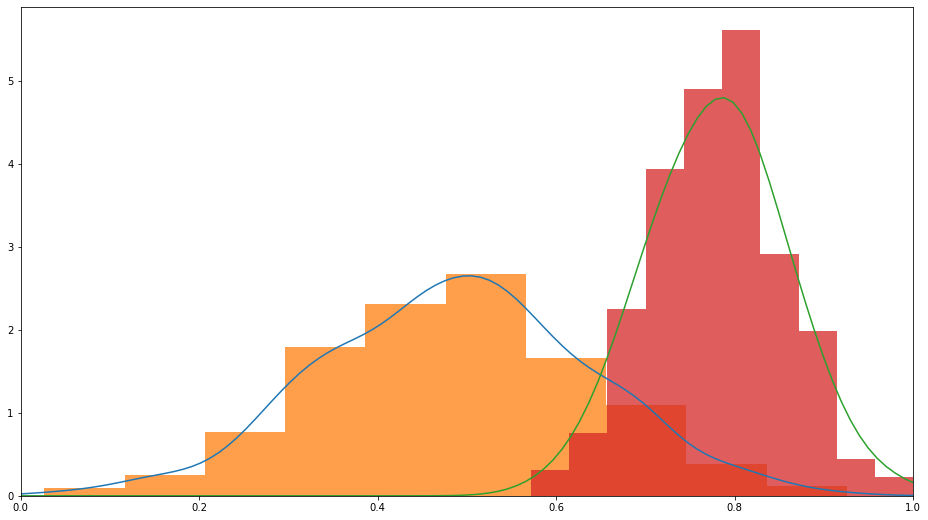

In [15]:
# hide

n_samples = 1024
n_classes = 2
batch_size = 1024

data = GaussianDataset(n_samples=n_samples, n_classes=n_classes)
dl = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
for x_cat, x_cont, y in dl:
    break
    
plot_class_hists(x_cat, x_cont)

In [9]:
## export
#
#class UniformDataset(torch.utils.data.Dataset):
#
#    def __init__(self, n_samples=1024, n_classes=2):
#        self.n_samples = n_samples
#        self.n_classes = n_classes
#        self.x_cat = torch.zeros(self.n_samples*self.n_classes, 1)
#        self.x_cont = torch.zeros(self.n_samples*self.n_classes, 1)
#        self.y = torch.zeros(self.n_samples*self.n_classes, 1)
#        self.mins = [0, 0, 0, 0]
#        self.maxs = [1, 1, 1, 1]
#        
#        self.generate_series()
#        self.x_cont = (self.x_cont-self.x_cont.min())/(self.x_cont.max()-self.x_cont.min())
#        
#    def generate_series(self):
#        for c in range(self.n_classes):
#            for idx in range(self.n_samples):
#                self.x_cat[c*self.n_samples + idx] = c+1
#                self.y[c*self.n_samples + idx] = c
#                self.x_cont[c*self.n_samples + idx] = torch.distributions.Uniform(self.mins[c], self.maxs[c]).rsample()
#        
#    def __len__(self):
#            return self.n_samples*self.n_classes
#
#    def __getitem__(self, idx):
#        x_cat = self.x_cat[idx, :]
#        x_cont = self.x_cont[idx, :]
#        y = self.y[idx, :]
#        return x_cat, x_cont, y

In [10]:
## hide
#
#data = UniformDataset(n_samples=n_samples, n_classes=n_classes)
#dl = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
#for x_cat, x_cont, y in dl:
#    break
#
#plot_class_hists(x_cat, x_cont)

In [11]:
## export
#
#torch.pi = 3.141592653589793
#
#class SineDataset(torch.utils.data.Dataset):
#
#    def __init__(self, n_samples=1000, n_classes=2, n_features=1, len_ts=24, noise=0.05, n_dim=2):
#        self.n_samples = n_samples
#        self.n_classes = n_classes
#        self.n_features = n_features
#        self.len_ts = len_ts
#        self.amp_min = 0.25
#        self.amp_max = 0.75
#        self.freq_min = 1.0
#        self.freq_max = 3.0
#        self.phase_min = 0.0
#        self.phase_max = 2.0*torch.pi
#        self.noise = noise
#        self.cat_data = torch.zeros(self.n_samples*self.n_classes, 1, self.len_ts)
#        self.cont_data = torch.zeros(self.n_samples*self.n_classes, self.n_features, self.len_ts)
#        self.target = torch.zeros(self.n_samples*self.n_classes, 1, self.len_ts)
#        self.n_dim = n_dim
#        
#        self.generate_series()
#        self.cont_data = (self.cont_data-self.cont_data.min())/(self.cont_data.max()-self.cont_data.min())
#        if self.n_dim==2:
#            self.reshape_2d()
#        
#    def generate_series(self):
#        for c in range(self.n_classes):
#            t = torch.linspace(0, 1, self.len_ts)
#            amplitudes = torch.linspace(self.amp_min, self.amp_max, self.n_classes)
#            frequencies = torch.linspace(self.freq_min, self.freq_max, self.n_classes)
#            phases = torch.linspace(self.phase_min, self.phase_max, self.n_classes)
#            for idx in range(self.n_samples):
#                self.cat_data[c*self.n_samples + idx, :, :] = c+1
#                self.target[c*self.n_samples + idx, :, :] = c
#                for f_idx in range(self.n_features):
#                    a = torch.ones_like(t)*amplitudes[c]
#                    f = torch.ones_like(t)*frequencies[c]
#                    p = torch.ones_like(t)*phases[c]
#                    self.cont_data[c*self.n_samples + idx, f_idx, :] = a*torch.sin(2*torch.pi*f*t + p) + self.noise*torch.randn_like(t)
#                    
#    def reshape_2d(self):
#        #todo: check if this works with n_features > 1
#        self.cat_data = self.cat_data.reshape(self.n_samples*self.n_classes*self.len_ts, 1)
#        self.cont_data = self.cont_data.reshape(self.n_samples*self.n_classes*self.len_ts, self.n_features)
#        self.target = self.target.reshape(self.n_samples*self.n_classes*self.len_ts, 1)
#        
#    def __len__(self):
#        if self.n_dim==2:
#            return self.n_samples*self.n_classes*self.len_ts
#        else:
#            return self.n_samples*self.n_classes
#
#    def __getitem__(self, idx):
#        x_cat = self.cat_data[idx, :]
#        x_cont = self.cont_data[idx, :]
#        y = self.target[idx, :]
#        return x_cat, x_cont, y

In [12]:
## hide
#
#data = SineDataset(n_samples=n_samples, n_classes=n_classes, n_features=n_features, len_ts=len_ts, n_dim=n_dim)
#dl = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
#for x_cat, x_cont, y in dl:
#    assert(x_cat.min() == 1 and x_cat.max() == n_classes)
#    assert(x_cont.max() <= 1 and x_cont.min() >= 0)
#    if n_dim==2:
#        assert(x_cat.shape == (batch_size, 1))
#        assert(x_cont.shape) == (batch_size, n_features)
#        assert(y.shape == (batch_size, 1))
#    if n_dim==3:
#        assert(x_cat.shape == (batch_size, 1, len_ts))
#        assert(x_cont.shape) == (batch_size, n_features, len_ts)
#        assert(y.shape == (batch_size, 1, len_ts))

In [13]:
## export
#
#def plot_sine_samples(dl):
#    plt.figure(figsize=(16, 9))
#    for _, x_cont, _ in dl:
#        for idx in range(x_cont.shape[0]):
#            plt.plot(x_cont[idx, 0, :])
#    plt.show()

In [14]:
## hide
#
#plot_sine_samples(dl)